In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1. Synthetic data generation

In [2]:
def true_fun(x, a=np.pi, b=0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x: x

    x = np.sum([ai * np.power(x, i + 1) for i, ai in enumerate(a)], axis=0)

    return f(x + b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max = 1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N)) * x_max    
    else:
        x = np.linspace(0, x_max, N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true = np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [3]:
def visualize_data(y, y_true, x, title):
    fig = plt.figure(figsize=(10, 7))
    plt.scatter(x[:, 0], y, edgecolor = 'b', label = "Noise data", s = 196, alpha = 0.6)
    plt.scatter(x[:, 0], y_true,label = "True data", s = 81, c = 'g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(fontsize=15)
    plt.title(title, fontsize=15)
    plt.xticks()
    plt.yticks();
    plt.tight_layout()
    plt.show()

### 1.1 Linear data

#### 1.1.1

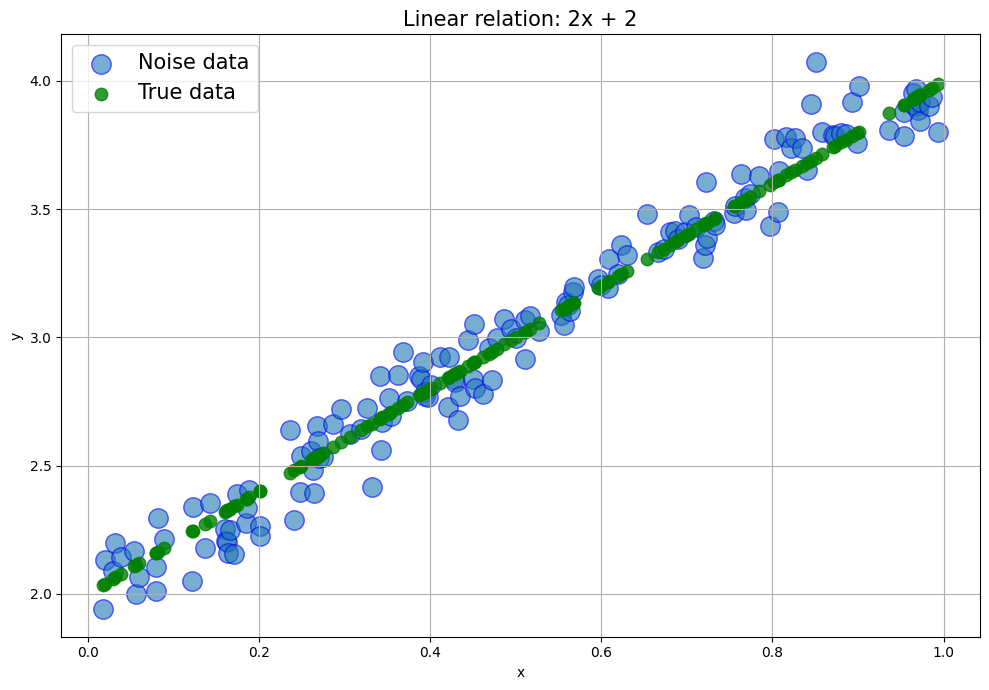

In [4]:
linear_1_y, linear_1_y_true, linear_1_x = dataset(
    a=2,
    b=2,
    f=None,
    N=150,
    x_max=1,
    noise_power=0.1,
    seed=33
)

visualize_data(linear_1_y, linear_1_y_true, linear_1_x, 'Linear relation: 2x + 2')

#### 1.1.2

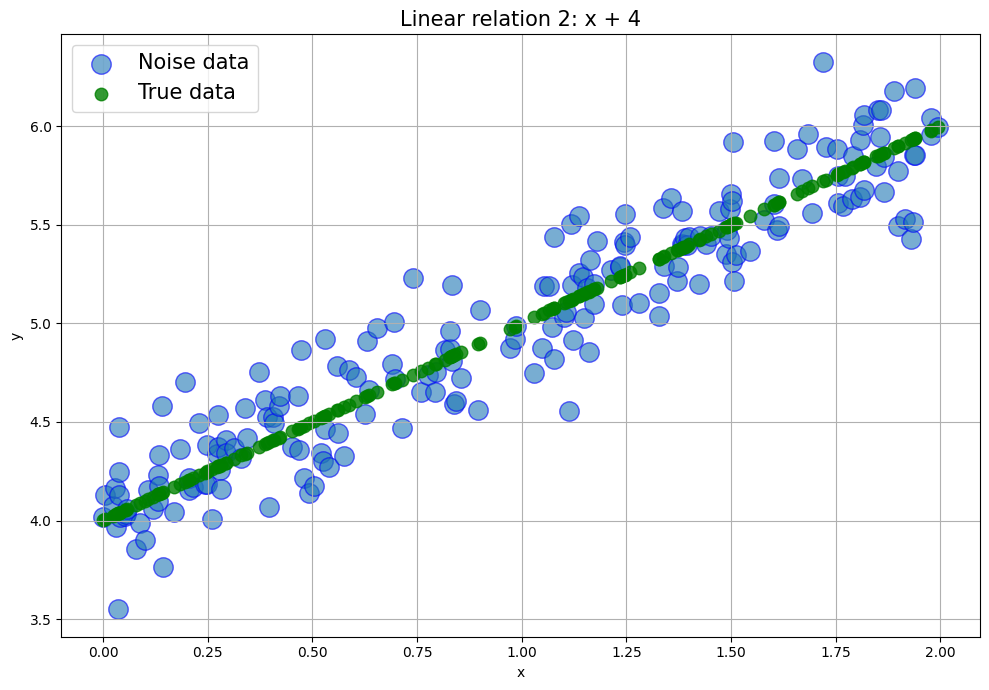

In [5]:
linear_2_y, linear_2_y_true, linear_2_x = dataset(
    a=1,
    b=4,
    f=None,
    N=200,
    x_max=2,
    noise_power=0.2,
    seed=1
)

visualize_data(linear_2_y, linear_2_y_true, linear_2_x, 'Linear relation 2: x + 4')

### 1.2 Sinusoidal relation

#### 1.2.1

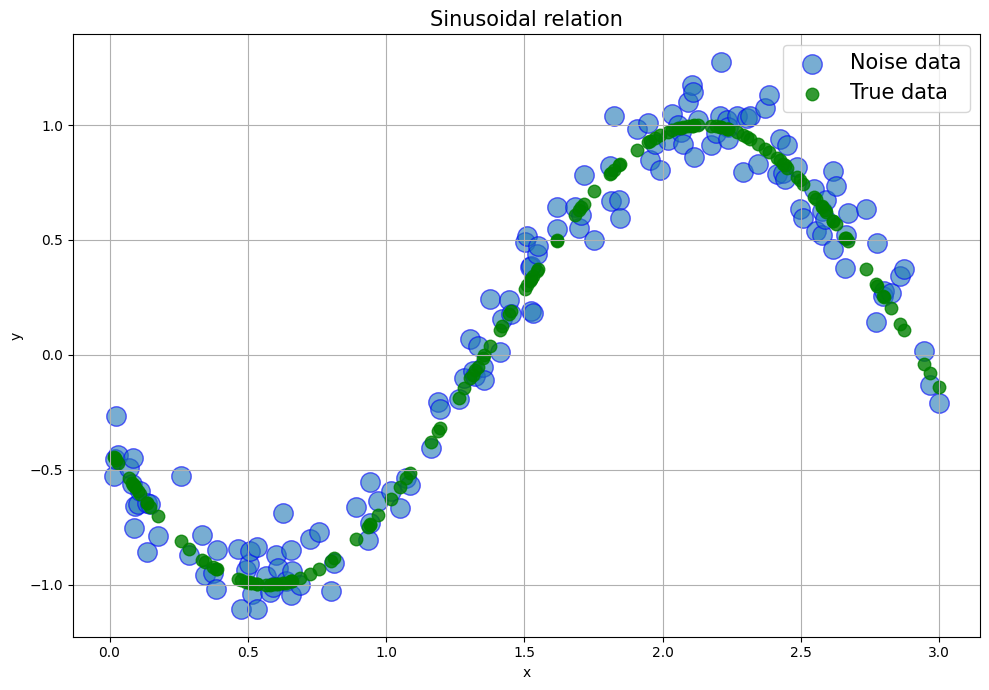

In [6]:
sinusoidal_y, sinusoidal_y_true, sinusoidal_x = dataset(
    a=2,
    b=2,
    f=np.cos,
    N=150,
    x_max=3,
    noise_power=0.1,
    seed=22
)

visualize_data(sinusoidal_y, sinusoidal_y_true, sinusoidal_x, 'Sinusoidal relation')

### 1.3 Polynomial data

#### 1.3.1

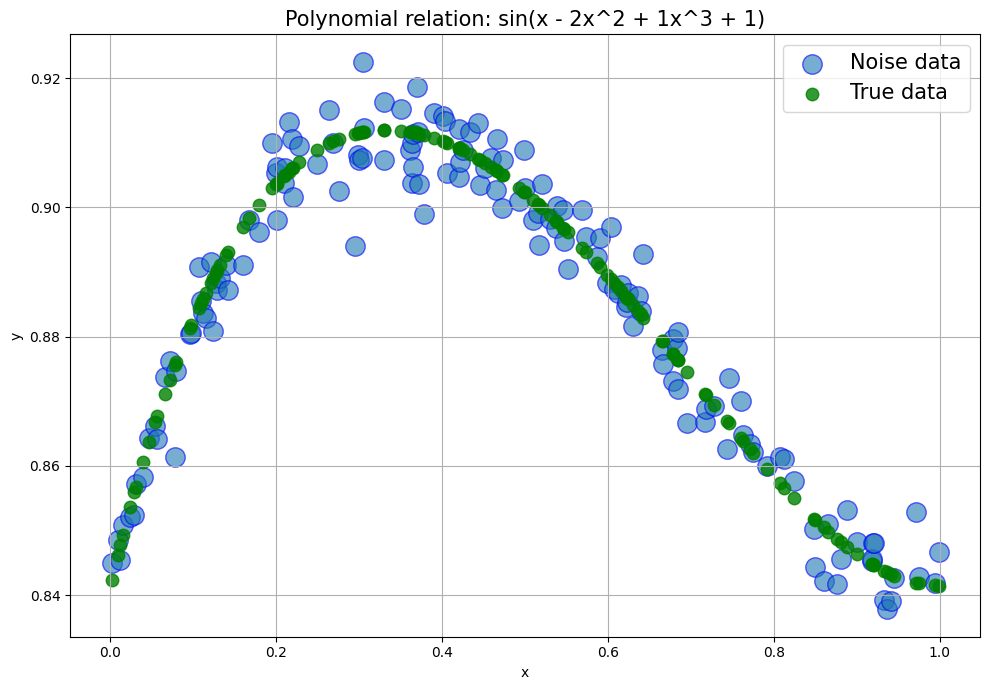

In [7]:
polynomial_1_y, polynomial_1_y_true, polynomial_1_x = dataset(
    a=[1, -2, 1],
    b=1,
    f=np.sin,
    N=150,
    x_max=1,
    noise_power=0.005,
    seed=15
)

visualize_data(polynomial_1_y, polynomial_1_y_true, polynomial_1_x, 'Polynomial relation: sin(x - 2x^2 + 1x^3 + 1)')

#### 1.3.2

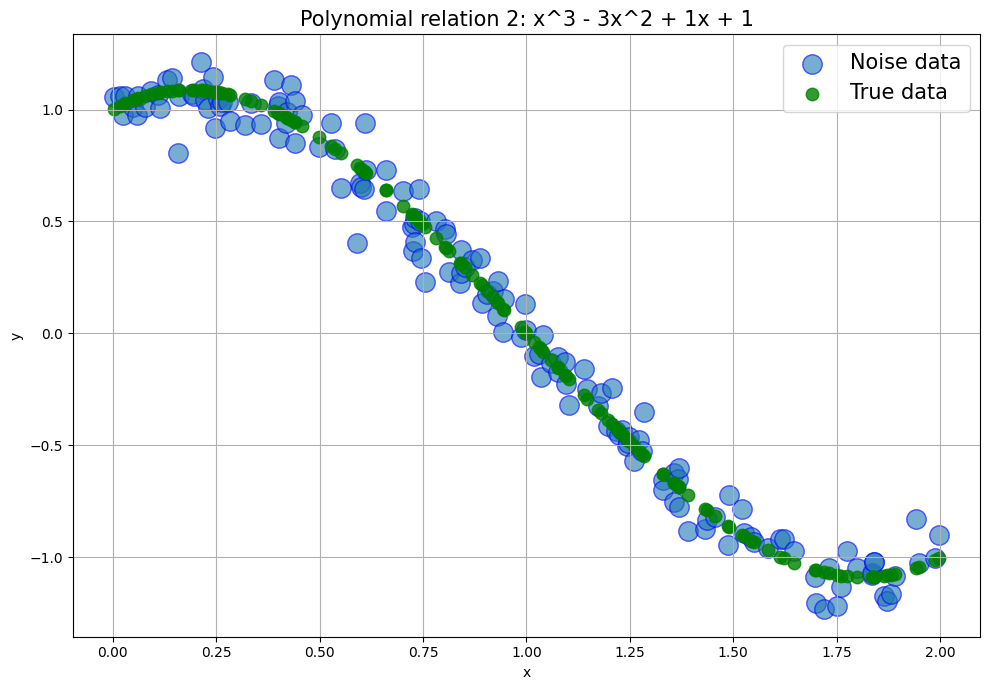

In [8]:
polynomial_2_y, polynomial_2_y_true, polynomial_2_x = dataset(
    a=[1, -3, 1],
    b=1,
    f=None,
    N=150,
    x_max=2,
    noise_power=0.1,
    seed=15
)

visualize_data(polynomial_2_y, polynomial_2_y_true, polynomial_2_x, 'Polynomial relation 2: x^3 - 3x^2 + 1x + 1')

#### 1.3.3

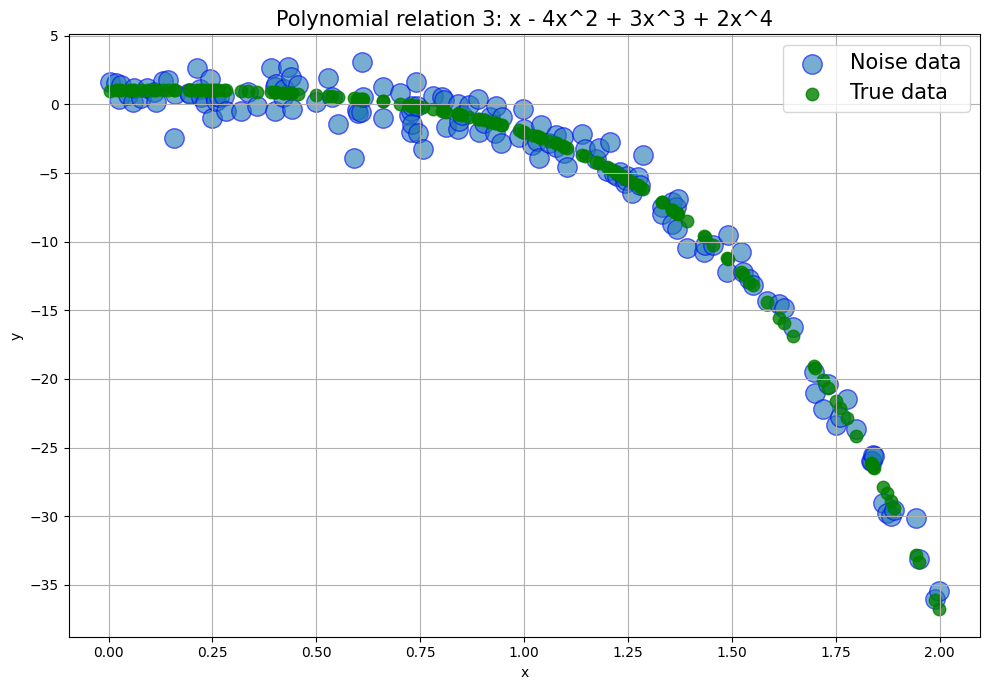

In [9]:
polynomial_3_y, polynomial_3_y_true, polynomial_3_x = dataset(
    a=[1, -4, 3, -3],
    b=1,
    f=None,
    N=150,
    x_max=2,
    noise_power=1.25,
    seed=15
)

visualize_data(polynomial_3_y, polynomial_3_y_true, polynomial_3_x, 'Polynomial relation 3: x - 4x^2 + 3x^3 + 2x^4')

### 2. 

In [10]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state:
        np.random.seed(random_state)

    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle:
        np.random.shuffle(idxs)

    if test_size and train_size is None:
        if (test_size <= 1):
            train_size = 1 - test_size

        else:
            train_size = size - test_size
        test_size = None   

    # ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
    if train_size is None or train_size > size:
        train_size = size

    if (train_size <= 1):
        train_size *= size

    if test_size is not None: 
        if test_size <= 1:
            test_size *= size    
        if test_size > size:
            test_size = size - train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val, y_val = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]

    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, x_val, x_test, y_train.squeeze(), y_val.squeeze(), y_test.squeeze() 

    return x_train, x_val, y_train.squeeze(), y_val.squeeze()

In [11]:
# linear_1_y, linear_1_y_true_line, linear_1_x


x_train, x_test, y_train, y_test = train_test_split(linear_1_x, linear_1_y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(105, 1) (105,) (45, 1) (45,)


In [12]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    """Генерация весов  
    Входные переменные:
    ===========
    W_shape: сколько весов надо (количество признаков)
    add_bias: учитываем смещение или нет
    random_state: фиксированный сид случайных чисел (для повторяемости)  
    """
    W_shape = np.atleast_1d(W_shape) # убеждаемся что данные - одномерный массив
    if random_state:  # фиксируем случайный seed
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))   # генерируем случайные числа с нулевым средним и дисперсией как корень из размерности весов
    if add_bias: # если учитываем смещение
        W = np.column_stack((np.zeros(W.shape[-1]),W )) # добавляем 0 в наш вектор весов
    return W.squeeze()

In [13]:
def predict( X, W, add_bias = True):
    """Предсказание линейной модели  
    Входные переменные:
    ===========
    X: признаки
    W: вектор весов
    add_bias: учитываем смещение или нет
    """
    if add_bias: # если учитываем смещение
        X_full = np.column_stack((np.ones(X.shape[0]),X)) # добавляем единички по количеству точек данных
    else:
        X_full = X # иначе ничего не делаем
    return  np.dot(X_full,W) # предсказание как матричное перемножение признаков на веса

In [14]:
def loss_func(yhat, y):
    """функция потерь  
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    """
    return np.square(yhat - y)  # функция потерь как квадрат разности предсказаний и реальных значений

##### x = linear_1_x y = linear_1_y

In [15]:
weights = init_weights(linear_1_x.shape[1]) # генерируем веса
yhat = predict(x_train[0], weights) # делаем предсказание на 1 точке
loss = loss_func(yhat, linear_1_y[0]) # посчитаем функцию потерь

print(f'Веса {weights}')

print(f'Первая точка-признак {x_train[0]},\n Предсказание {yhat},\n Реальное значение {linear_1_y[0]},\n Функция потерь: {loss}')

Веса [0.         0.49671415]
Первая точка-признак [0.47238787],
 Предсказание [0.23464174],
 Реальное значение [1.93919384],
 Функция потерь: [2.90549786]


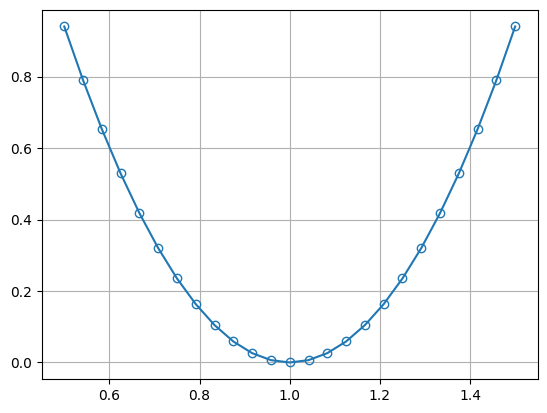

In [16]:
decline = np.linspace(start = 0.5, stop = 1.5,num = 25) # созданим вектор "пропорций" от 50% до 150%
yhat = decline * linear_1_y[0] # на примере 1 точке 
loss = loss_func(yhat, linear_1_y[0]) # посчитаем функцию потерь 
plt.plot(decline,loss,'-o', mfc = 'none'); plt.grid();  # визуализируем

In [17]:
def grad_loss(y_hat, y, X, add_bias = True):
    """Оценим градиент функции потерь  
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    X: признаки
    add_bias: учитываем смещение или нет
    """
    if add_bias: # если учитываем смещение
        X_full = np.column_stack((np.ones(X.shape[0]), X)) # добавляем единички по количеству точек данных
    else:
        X_full = X # иначе ничего не делаем
  
    return 2 * np.dot(X_full.T, (y_hat - y)) / y.size  # градиент функции потерь как среднее от матричного умножения признаков на разницу предсказание-реальное

In [18]:
yhat = predict(x_train[0], weights) # делаем предсказание на 1 точке

grad = grad_loss(yhat, linear_1_y[0], linear_1_x[0]) # делаем оценку градиента функции потерь
print(grad)

[-3.4091042  -0.05922305]


In [19]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    """Отрисовка модели.   
    Входные переменные:
    ===========
    x_train: признаки на которых тренировались
    y_train: тренировочные целевые значения
    x_test: тестовые признаки
    x: полные признаки
    y: реальные целевые значения (без шума)
    weights: веса
    """

    # отдельно визуализируем
    # Предсказание на x_train
    #                           ↓ считаем предсказания с использованием написанное ранее функции predict
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    # Предсказание на x_test
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    # Тренировочные данные
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    # Истинные Значения
    plt.plot(x[:,0], y, '--',
            label="Истинные значения", linewidth=4,c='g')
    # отличие в типе маркера, прозрачности и размере
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);

In [21]:
x_train, x_test, y_train, y_test = train_test_split(linear_1_y, linear_1_x,  test_size=0.3)    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape)

(105, 1) (105,) (45, 1) (45,)


In [23]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    """Генерация весов  
    Входные переменные:
    ===========
    W_shape: сколько весов надо (количество признаков)
    add_bias: учитываем смещение или нет
    random_state: фиксированный сид случайных чисел (для повторяемости)  
    """
    W_shape = np.atleast_1d(W_shape) # убеждаемся что данные - одномерный массив
    if random_state:  # фиксируем случайный seed
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))   # генерируем случайные числа с нулевым средним и дисперсией как корень из размерности весов
    if add_bias: # если учитываем смещение
        W = np.column_stack((np.zeros(W.shape[-1]),W )) # добавляем 0 в наш вектор весов
    return W.squeeze()

In [24]:
def predict( X, W, add_bias = True):
    """Предсказание линейной модели  
    Входные переменные:
    ===========
    X: признаки
    W: вектор весов
    add_bias: учитываем смещение или нет
    """
    if add_bias: # если учитываем смещение
        X_full = np.column_stack((np.ones(X.shape[0]),X)) # добавляем единички по количеству точек данных
    else:
        X_full = X # иначе ничего не делаем
    return  np.dot(X_full,W) # предсказание как матричное перемножение признаков на веса

def loss_func(yhat, y):
    """функция потерь  
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    """
    return np.square(yhat - y)  # функция потерь как квадрат разности предсказаний и реальных значений

In [25]:
# weights = init_weights(x.shape[1]) # генерируем веса
weights = init_weights(linear_1_x.shape[1])

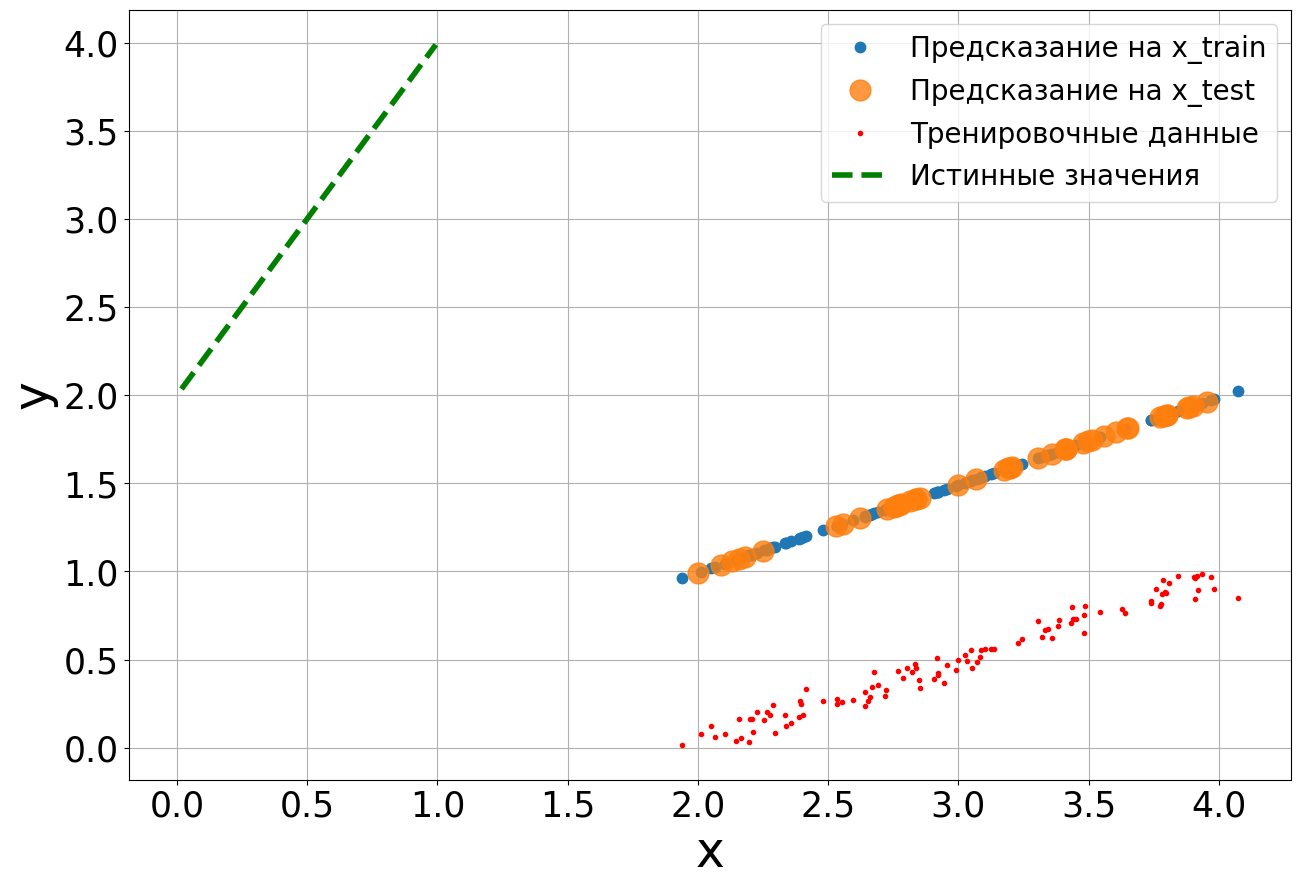

In [26]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, linear_1_x, linear_1_y_true, weights)

In [29]:
def vis_weigths(weights):
    numbers = np.arange(0, len(weights))
    tick_labels = ['w' + str(num) for num in numbers]
    cc = [''] * len(numbers)
    for n,val in enumerate(weights):
        if val < 0:
            cc[n] = 'red'
        elif val >= 0:
            cc[n] = 'blue'

    plt.bar(x = numbers, height = weights, color = cc) 
    plt.xticks(np.arange(0, len(weights)), tick_labels);

In [28]:
class LinearRegression():
    def __init__(self, 
            learning_rate = 0.5, 
            epochs = 100, 
            weights = None, 
            bias    = None, 
            batch_size   = 1000,
            n_batches    = None,
            random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)        
        self.n_batches = n_batches
    
    
    def forward(self, X):
        return np.dot(X, self.weights)
    
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    def update(self):    
        return self.weights - self.lr*self.grad
    
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    def score(self, X, y):    
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    def fit(self, X, y):
        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None:
            self.bias = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad = np.zeros(self.weights.shape)
        self.cost = np.zeros(self.epochs)

        if self.batch_size is None:  
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs):
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]

    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
   
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Epoch', fontsize = 24)
        plt.ylabel('Loss function', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
   
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)